# Credit Risk Analysis

[Dataset Source](https://www.kaggle.com/datasets/laotse/credit-risk-dataset)

| **Feature Name** | **Description** |
| --- | --- |
|person_age	| Age | 
|person_income	| Annual Income |
|person_home_ownership	| Home ownership |
|person_emp_length	| Employment length (in years) |
|loan_intent	| Loan intent |
|loan_grade	| Loan grade |
|loan_amnt	| Loan amount |
|loan_int_rate	| Interest rate |
|loan_status	| Loan status (0 is non default 1 is default) |
|loan_percent_income	| Percent income |
|cb_person_default_on_file	| Historical default |
|cb_preson_cred_hist_length	| Credit history length |

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("dark:#5A9_r")

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report


import imblearn
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.shape

(32581, 12)

In [5]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
delete_row = sum([True for idx, row in df.iterrows() if any(row.isnull())])
delete_row

3943

In [7]:
delete_row/len(df)

0.1210214542217857

Since the observations with n.a. values represent only 12% of the dataset, we decided delete these lines.

In [8]:
df.dropna(inplace=True)

In [9]:
print("New dataset size:",len(df))

New dataset size: 28638


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


# Exploratory Analysis

In [11]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [12]:
print("Age over 90")
print(df.query("person_age>=90")["person_age"].value_counts())
print("----------------------------------------------------")
print("Income over $",round(df.person_income.mean()+5*df.person_income.std(),0),"(zscore = 5)")
print("----------------------------------------------------")
print("Career lengh over 50")
print(df.query("person_emp_length>=50")["person_emp_length"].value_counts())

Age over 90
144    3
123    1
Name: person_age, dtype: int64
----------------------------------------------------
Income over $ 378432.0 (zscore = 5)
----------------------------------------------------
Career lengh over 50
123.0    2
Name: person_emp_length, dtype: int64


**Observation: Some columns present unrealistic data and the outliers need to be removed, these are:**

- person_age: Most people are under 30 years old. In the above table, the maximum value is 144 years old, so, to be more general, people age > 90 will be removed.
- person_income: It seems that there are outliers which has to be removed (> $ 378.432).
- person_emp_length: Most people have less than 7 years of employment. People with employment > 50 years will be removed.
- For all other variables, the distribution is more uniform across the whole range, thus they will be kept.

In [13]:
unrealistic_age = df.query("person_age>=90").index
df.drop(unrealistic_age, inplace=True)

In [14]:
high_income = df.query("person_income>=378432").index
df.drop(high_income, inplace=True)

In [15]:
high_emp_length = df.query("person_emp_length>=50").index
df.drop(high_emp_length, inplace=True)

In [16]:
print("New shape:", df.shape)

New shape: (28552, 12)


Total per category:
 0    22358
1     6194
Name: loan_status, dtype: int64


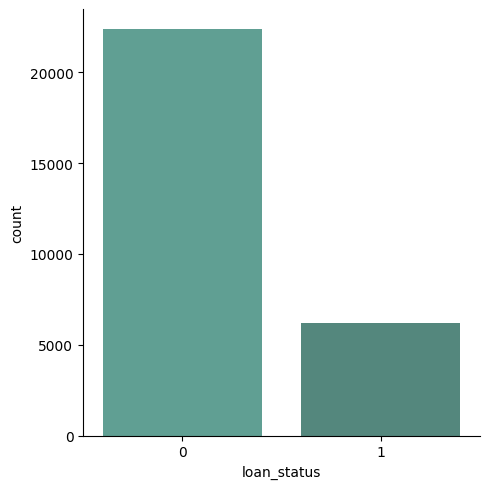

In [17]:
sns.catplot(x="loan_status", kind="count", data=df)
print("Total per category:\n", df.loan_status.value_counts())

### Age Analysis

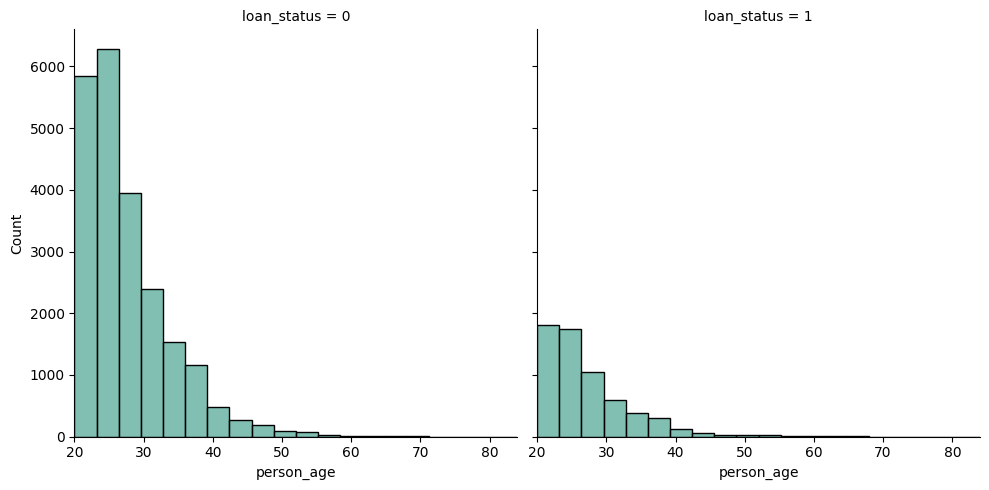

In [18]:
plot = sns.displot(x="person_age", kind='hist', col="loan_status", bins = 20, data=df)
plot.set(xlim=(df["person_age"].min(),df["person_age"].max()))

- We can see that people who are younger tend not to pay back the loan, 0 did and 1 did not. Also, according to the graphs above, the loans are concentrated on people under 30 years old.

### Person income Analysis

Count of Person income x1000


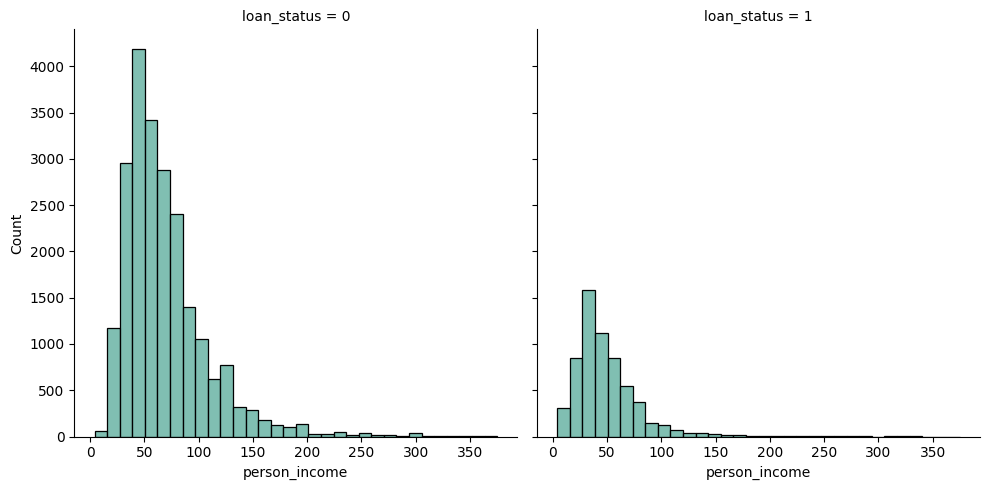

In [19]:
print ('\033[1m' + "Count of Person income x1000" + '\033[0m')
plot = sns.displot(x=df["person_income"]/1000, kind='hist', col="loan_status", bins = 32, data=df)

In [20]:
print("Percentage of people who don't pay back the loan in terms of income")
print("Income more than 50K -",len(df.query("person_income>=50000 and loan_status == 1"))/len(df.query("person_income>=50000")))
print("Income less than 50K -",len(df.query("person_income<=50000 and loan_status == 1"))/len(df.query("person_income<=50000")))
print("Income less than 25K -",len(df.query("person_income<=25000 and loan_status == 1"))/len(df.query("person_income<=25000")))
print("Income less than 20K -",len(df.query("person_income<=20000 and loan_status == 1"))/len(df.query("person_income<=20000")))
print("Income less than 15K -",len(df.query("person_income<=15000 and loan_status == 1"))/len(df.query("person_income<=15000")))

Percentage of people who don't pay back the loan in terms of income
Income more than 50K - 0.13998475877835748
Income less than 50K - 0.3175842235004108
Income less than 25K - 0.5141987829614605
Income less than 20K - 0.7442116868798236
Income less than 15K - 0.8342696629213483


- According to the chart, the lower the income, the higher the risk of the loan not being paid back. (50% of people who borrowed with income up to 25k did not pay back)

### Person home ownership Analysis

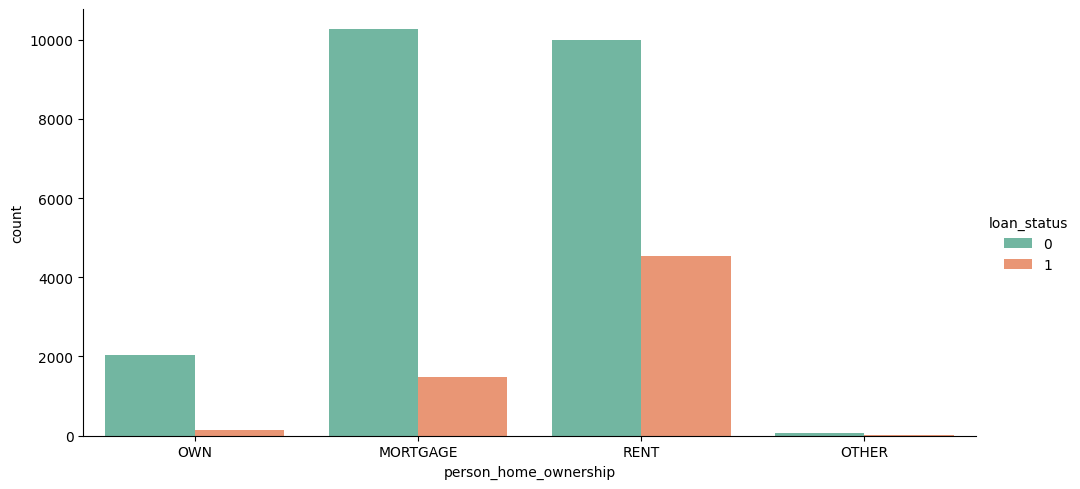

In [21]:
sns.catplot(data=df, x="person_home_ownership", kind="count", hue="loan_status", aspect=2, palette="Set2")

- People who pay rent on their homes are those who don't pay the loan.

### Loan intent Analysis

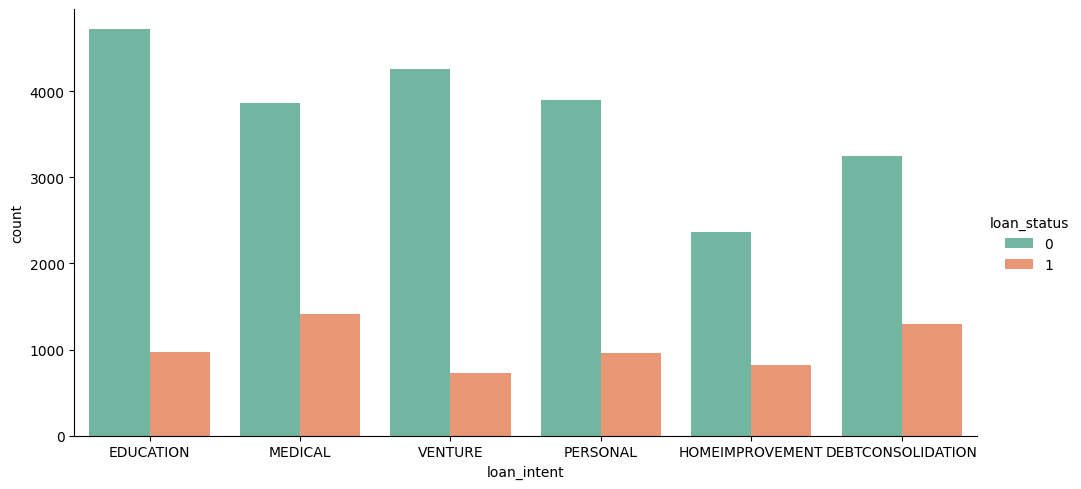

In [22]:
sns.catplot(data=df, x="loan_intent", kind="count", hue="loan_status", aspect=2, palette="Set2")

### Loan grade Analysis

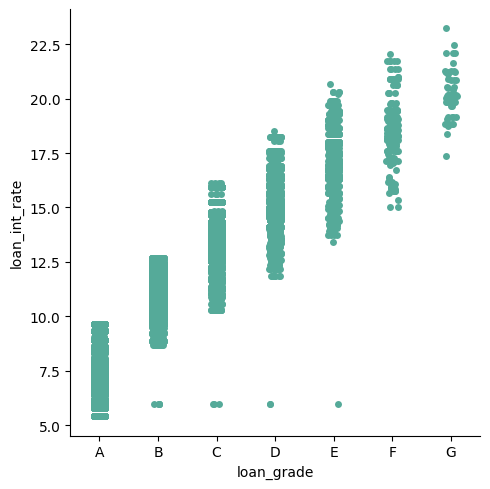

In [23]:
sns.catplot(x="loan_grade", y="loan_int_rate", order=["A","B","C","D","E","F","G"], data=df)

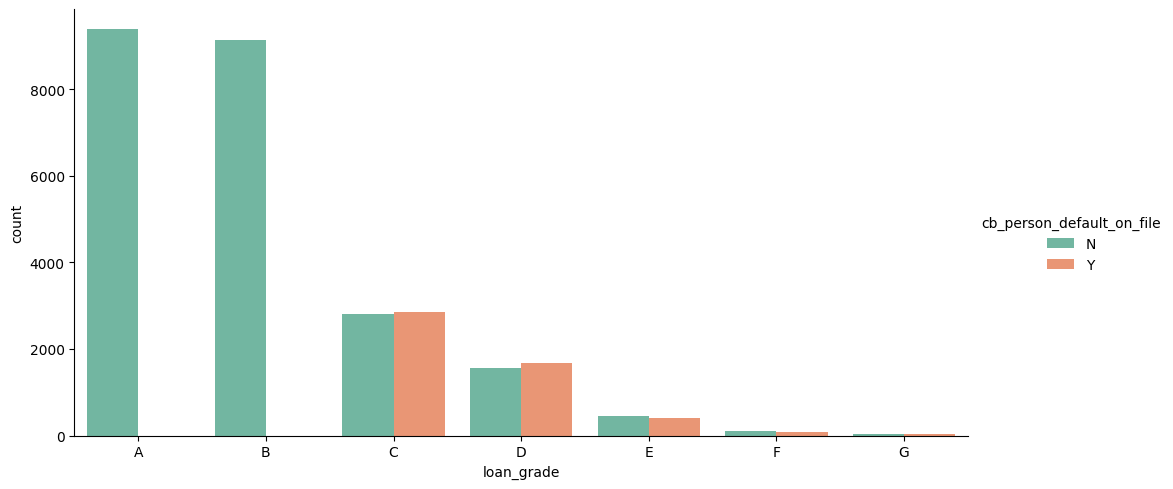

In [24]:
sns.catplot(data=df, x="loan_grade", kind="count", hue="cb_person_default_on_file", aspect=2, order=["A","B","C","D","E","F","G"], palette="Set2")

- The two charts above show that to have the lowest interest rate through grade A and B, you must have no history of default

### LabelEncoder

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28552 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28552 non-null  int64  
 1   person_income               28552 non-null  int64  
 2   person_home_ownership       28552 non-null  object 
 3   person_emp_length           28552 non-null  float64
 4   loan_intent                 28552 non-null  object 
 5   loan_grade                  28552 non-null  object 
 6   loan_amnt                   28552 non-null  int64  
 7   loan_int_rate               28552 non-null  float64
 8   loan_status                 28552 non-null  int64  
 9   loan_percent_income         28552 non-null  float64
 10  cb_person_default_on_file   28552 non-null  object 
 11  cb_person_cred_hist_length  28552 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.8+ MB


In [26]:
categoric_var = df.select_dtypes(include=['object']).columns
categoric_var

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [27]:
#Deep copy the original data
df_e = df.copy(deep=True)

le = LabelEncoder()
for col in categoric_var:
        df_e[col] = le.fit_transform(df[col])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)

Feature person_home_ownership
mapping {'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}
Feature loan_intent
mapping {'DEBTCONSOLIDATION': 0, 'EDUCATION': 1, 'HOMEIMPROVEMENT': 2, 'MEDICAL': 3, 'PERSONAL': 4, 'VENTURE': 5}
Feature loan_grade
mapping {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Feature cb_person_default_on_file
mapping {'N': 0, 'Y': 1}


### Correlation Analysis

In [28]:
corr_matrix = df_e.corr()

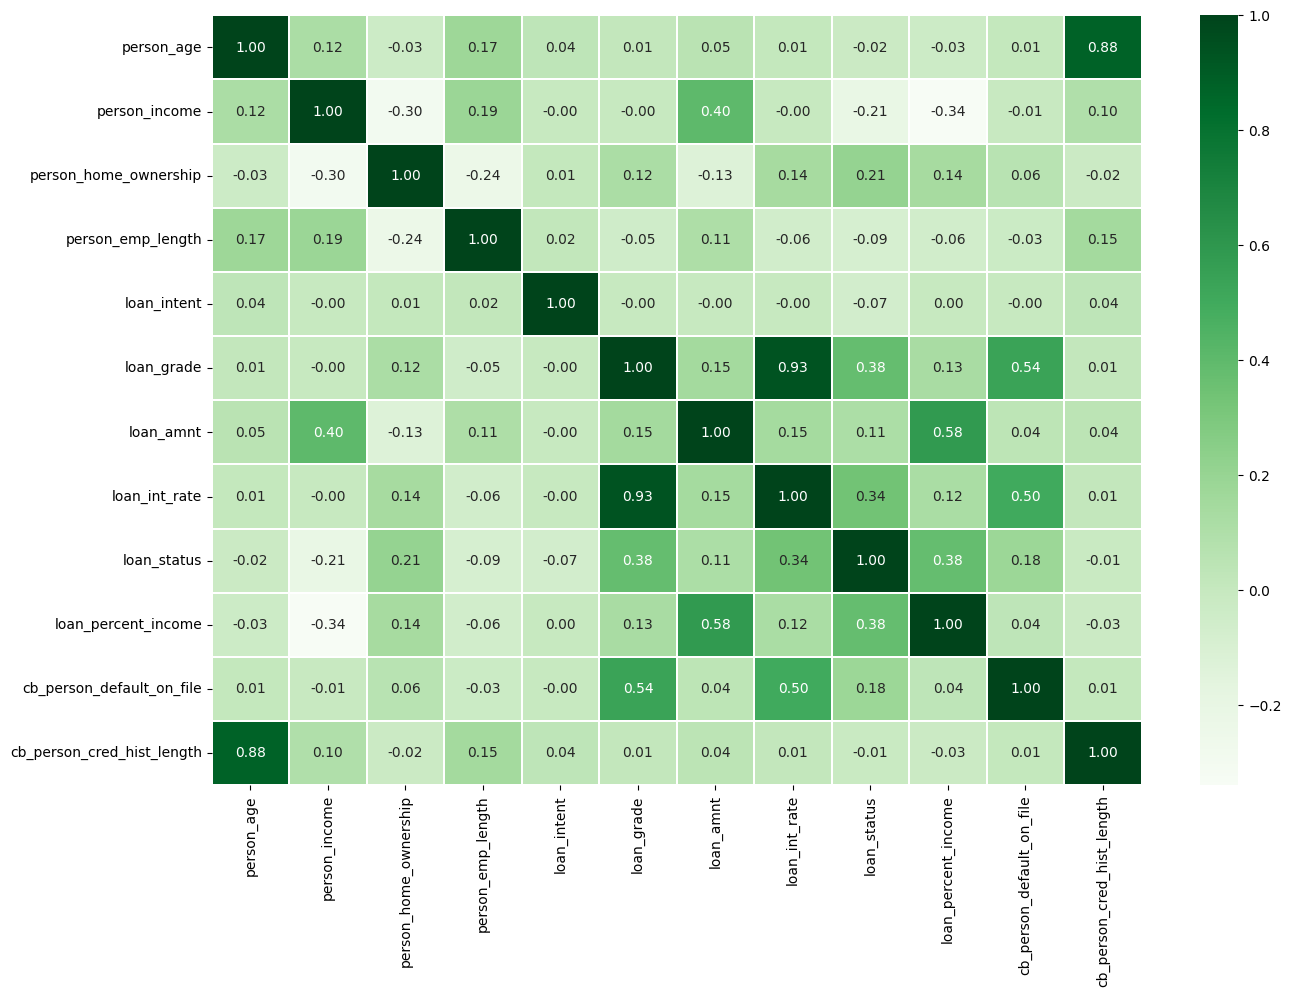

In [29]:
plt.rcParams["figure.figsize"] = [15,10]
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns,yticklabels=corr_matrix.columns,linewidths=.1,cmap="Greens", annot=True, fmt='.2f')
plt.show()

In [30]:
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

#first element of sol series is the pair with the biggest correlation
sol

loan_grade             loan_int_rate                 0.933485
person_age             cb_person_cred_hist_length    0.876968
loan_amnt              loan_percent_income           0.584506
loan_grade             cb_person_default_on_file     0.535530
loan_int_rate          cb_person_default_on_file     0.499981
                                                       ...   
person_home_ownership  loan_amnt                    -0.128099
person_income          loan_status                  -0.208723
person_home_ownership  person_emp_length            -0.239055
person_income          person_home_ownership        -0.296613
                       loan_percent_income          -0.339920
Length: 66, dtype: float64

In [31]:
print(sol.min())
print(sol.max())

-0.33991980836603386
0.9334846894452661


In [32]:
df_corr = pd.DataFrame(sol).reset_index()

In [33]:
df_corr.rename(columns = {'level_0':'Var1', 'level_1':'Var2',
                              0:'Corr'}, inplace = True)

In [34]:
df_corr.query("Var1 == 'loan_status' or Var2 == 'loan_status'")

,Var1,Var2,Corr
6,loan_status,loan_percent_income,0.379756
7,loan_grade,loan_status,0.379677
8,loan_int_rate,loan_status,0.339343
9,person_home_ownership,loan_status,0.208579
11,loan_status,cb_person_default_on_file,0.181619
22,loan_amnt,loan_status,0.114652
49,loan_status,cb_person_cred_hist_length,-0.014295
50,person_age,loan_status,-0.021189
59,loan_intent,loan_status,-0.065080
60,person_emp_length,loan_status,-0.086679


**Observation:**

- person_income, person_emp_length, and person_age: has negative effect on loan_status being default, which means the larger these variebles, the less likely the person is risky.
- loan_percent_income, loan_int_rate, and loan_amnt: has postive effect on loan_status being default, which means the larger these variebles, the more likely the person is risky.

In [35]:
df_high_corr = df_corr.query("Corr>=0.5 or Corr<=-0.5")
df_high_corr

,Var1,Var2,Corr
0,loan_grade,loan_int_rate,0.933485
1,person_age,cb_person_cred_hist_length,0.876968
2,loan_amnt,loan_percent_income,0.584506
3,loan_grade,cb_person_default_on_file,0.535530


# Division of dataset into training and testing

In [36]:
#Target
y = df_e.loan_status

In [37]:
#Features (and removing the freatures with high correlation)
X = df_e.drop(['loan_grade','cb_person_cred_hist_length', 'loan_status','person_age','loan_amnt'], axis = 1)

In [38]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.30,
                                                        shuffle=True,
                                                        random_state = 1234)

In [39]:
len(X_train)

19986

In [40]:
len(X_test)

8566

In [41]:
y_train.value_counts()

0    15610
1     4376
Name: loan_status, dtype: int64

Let's apply the oversampling technique and increase the number of examples of the minority class


In [42]:
over_sampler = SMOTE(k_neighbors = 2)

In [43]:
X_res, y_res = over_sampler.fit_resample(X_train, y_train)

In [44]:
len(X_res)

31220

In [45]:
len(y_res)

31220

In [46]:
y_res.value_counts()

0    15610
1    15610
Name: loan_status, dtype: int64

In [47]:
#renaming the vars
X_train = X_res

y_train = y_res

## Standardize the Data

In [48]:
scaler = MinMaxScaler()

In [49]:
scaler.fit(X_train)

MinMaxScaler()

In [50]:
X_train = scaler.transform(X_train)

In [51]:
X_test = scaler.transform(X_test)

## Model 1 - Logistic Regression (Benchmark)

In [52]:
# all parameters not specified are set to their defaults
logreg = LogisticRegression(random_state=16)

In [53]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [54]:
y_pred1 = logreg.predict(X_test)

In [55]:
cnf_matrix1 = confusion_matrix(y_test, y_pred1)
cnf_matrix1

array([[5165, 1583],
       [ 460, 1358]], dtype=int64)

In [56]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.77      0.83      6748
           1       0.46      0.75      0.57      1818

    accuracy                           0.76      8566
   macro avg       0.69      0.76      0.70      8566
weighted avg       0.82      0.76      0.78      8566



## Model 2 - Decision Tree

In [57]:
# Create Decision Tree classifer object
d_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=1234)

In [58]:
# Train Decision Tree Classifer
d_tree = d_tree.fit(X_train,y_train)

In [59]:
#Predict the response for test dataset
y_pred2 = d_tree.predict(X_test)

In [60]:
cnf_matrix2 = confusion_matrix(y_test, y_pred2)
cnf_matrix2

array([[6123,  625],
       [ 464, 1354]], dtype=int64)

In [61]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6748
           1       0.68      0.74      0.71      1818

    accuracy                           0.87      8566
   macro avg       0.81      0.83      0.82      8566
weighted avg       0.88      0.87      0.87      8566



## Model 3 - XGBooster

In [62]:
# instanciar o modelo XGBoost
xgb = XGBClassifier(n_estimators = 650,
                    max_depth = 10, 
                    learning_rate = 0.01,
                    subsample = 1,
                    random_state=0)

In [63]:
# Training the XGB classifier
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=650, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [64]:
#Predict the response for test dataset
y_pred3 = xgb.predict(X_test)

In [65]:
cnf_matrix3 = confusion_matrix(y_test, y_pred3)
cnf_matrix3

array([[6517,  231],
       [ 487, 1331]], dtype=int64)

In [66]:
print(classification_report(y_test, y_pred3, target_names=target_names))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6748
           1       0.85      0.73      0.79      1818

    accuracy                           0.92      8566
   macro avg       0.89      0.85      0.87      8566
weighted avg       0.91      0.92      0.91      8566



## Model 4 - XGBooster with GridSearch

In [67]:
params = {
    "colsample_bytree": [0.9, 0.91],
    "gamma": [0.45],
    "learning_rate": [0.30],
    "max_depth": [8],
    "n_estimators": [150, 155, 160],
    "subsample": [0.98, 0.97, 0.96]}

In [68]:
xgb2 = XGBClassifier()

In [69]:
grid_xgb = GridSearchCV(xgb2, param_grid = params ,scoring = 'recall')

In [70]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.9, 0.91], 'gamma': [0.45],
                         'learning_rate': [0.3], 'max_depth': [8],
                         'n_estimators': [150, 155, 160],
                         'subsample': [0.98, 0.97, 0.96]},
             scoring='recall')

In [71]:
print(grid_xgb.best_params_) 

{'colsample_bytree': 0.9, 'gamma': 0.45, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.96}


In [72]:
y_pred4 = grid_xgb.predict(X_test)

In [73]:
cnf_matrix4 = confusion_matrix(y_test, y_pred4)
cnf_matrix4

array([[6584,  164],
       [ 451, 1367]], dtype=int64)

In [74]:
print(classification_report(y_test, y_pred4, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6748
           1       0.89      0.75      0.82      1818

    accuracy                           0.93      8566
   macro avg       0.91      0.86      0.89      8566
weighted avg       0.93      0.93      0.93      8566



# Feature importance

In [75]:
Grid_best_xgb = grid_xgb.best_estimator_

In [76]:
Grid_best_xgb.feature_importances_

array([0.10449699, 0.21216448, 0.12566958, 0.1250191 , 0.13311826,
       0.22129717, 0.0782344 ], dtype=float32)

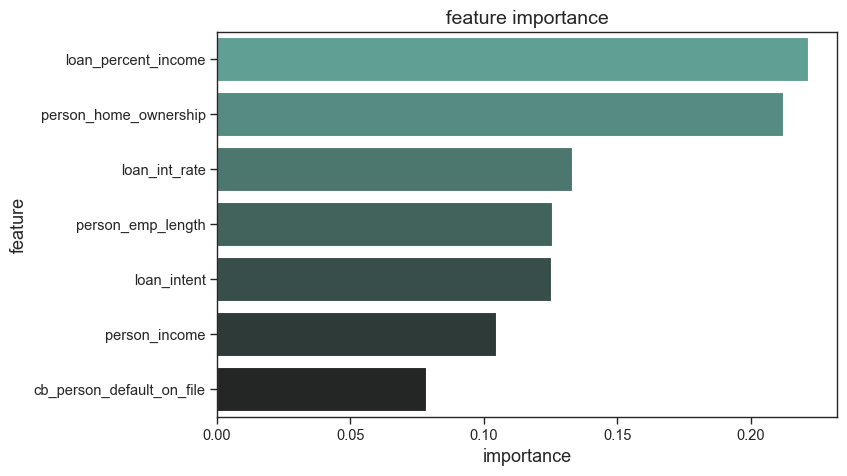

In [77]:
# display feature and their importance of the best model
feature_importance = pd.DataFrame({'feature': X.columns, 
                                   'importance': Grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='dark:#5A9_r')
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()